# Actor Critic Agent for MiniHack-Quest-Hard-v0 using Limited Actions

# Setup

Just doing installs of needed libraries so notebook can run on Colab.

In [ ]:
 !sudo apt-get install -y build-essential autoconf libtool pkg-config \
     python3-dev python3-pip python3-numpy git libncurses5-dev \
     libzmq3-dev flex bison
!git clone https://github.com/google/flatbuffers.git
!cd flatbuffers && cmake -G "Unix Makefiles" && make && sudo make install
!pip install cmake==3.15.3
!pip install nle
!pip install pyvirtualdisplay
!pip install minihack

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
pkg-config is already the newest version (0.29.1-0ubuntu2).
git is already the newest version (1:2.17.1-1ubuntu0.9).
libncurses5-dev is already the newest version (6.1-1ubuntu1.18.04).
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
libzmq3-dev is already the newest version (4.2.5-1ubuntu0.2).
The following additional packages will be installed:
  automake autotools-dev file libbison-dev libfl-dev libfl2 libmagic-mgc
  libmagic1 libsigsegv2 m4 python-pip-whl python3-asn1crypto
  python3-cffi-backend python3-crypto python3-cryptography python3-idna
  python3-keyring python3-keyrings.alt python3-pkg-resources
  python3-secretstorage python3-setuptools python3-six python3-wheel
  python3-xdg
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext bison-doc flex-doc
  

# Imports

Just doing imports of needed libraries so notebook can run on Colab.

In [ ]:
import os
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import gym
import nle
import random
from gym import spaces
from nle import nethack
import minihack
from minihack import RewardManager
from collections import deque
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torch.distributions import Categorical

Ensures pytorch uses the correct device and that we have the correct directory to be used.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cwd = os.getcwd()

Mount google drive on Colab so files can be accessed and made. 

In [ ]:
Colab = True

if Colab:
    from google.colab import files, drive
    drive.mount('/content/drive')
    dir = '/content/drive/My Drive/Colab Notebooks/Actor Critic Agents/Actor Critic - Limited Actions Agent/'
    os.makedirs(dir, exist_ok=True)
else:
    dir = './'

path = lambda fname: os.path.join(dir, fname)


Mounted at /content/drive


# Actor Critic Model Class

Here we have define our Actor Critic Model Network and its necessary functions.

In [ ]:
class ACNetwork(nn.Module):
    def __init__(self,observation_shape,num_actions):
        super(ACNetwork, self).__init__()
        #use colors_crop as observation space
        self.glyph_shape = observation_shape["colors_crop"].shape
        #size of blstats which is included in observation space
        self.blstats_size = 12 
        #num actions available
        self.num_actions = num_actions
        #get height and width of colors_crop
        self.H = self.glyph_shape[0]
        self.W = self.glyph_shape[1]

        #set some constants to be used in the network
        self.k_dim = 32
        self.h_dim = 128
        self.crop_dim = 3
        #get crop dimensions
        self.crop = Crop(self.H, self.W, self.crop_dim, self.crop_dim)
        #make lookup table that stores embeddings of a fixed dictionary and size
        self.embed = nn.Embedding(16, self.k_dim)

        #set more constants to be used in the network
        K = 32  # number of input filters
        F = 3  # filter dimensions
        S = 1  # stride
        P = 1  # padding
        M = 16  # number of intermediate filters
        Y = 8  # number of output filters
        L = 2  # number of convnet layers

        #determine input size for network
        in_channels = [K] + [M] * (L - 1)
        #determine output size for network
        out_channels = [M] * (L - 1) + [Y]

        def interleave(xs, ys):
            return [val for pair in zip(xs, ys) for val in pair]

        # CNN normal model
        conv_extract = [nn.Conv2d(in_channels=in_channels[i],out_channels=out_channels[i],kernel_size=(F, F),stride=S,padding=P,)for i in range(L)]
        self.extract_representation = nn.Sequential(*interleave(conv_extract, [nn.ELU()] * len(conv_extract)))

        # CNN crop model
        conv_extract_crop = [nn.Conv2d(in_channels=in_channels[i],out_channels=out_channels[i],kernel_size=(F, F),stride=S,padding=P,)for i in range(L)]
        self.extract_crop_representation = nn.Sequential(*interleave(conv_extract_crop, [nn.ELU()] * len(conv_extract_crop)))

        out_dim = self.k_dim
        # CNN over full glyph map
        out_dim += self.H * self.W * Y
        # CNN over full crop model
        out_dim += self.crop_dim ** 2 * Y

        # define policy,state_value among other things 
        self.embed_blstats = nn.Sequential(nn.Linear(self.blstats_size, self.k_dim),nn.ReLU(),nn.Linear(self.k_dim, self.k_dim),nn.ReLU(),)
        self.fc = nn.Sequential(nn.Linear(out_dim, self.h_dim),nn.ReLU(),nn.Linear(self.h_dim, self.h_dim),nn.ReLU(),)
        self.policy = nn.Linear(self.h_dim, self.num_actions)
        self.state_value = nn.Linear(self.h_dim, 1)

    # make backward pass of embedding faster
    def _select(self, embed, x):
        out = embed.weight.index_select(0, x.reshape(-1))
        return out.reshape(x.shape + (-1,))

    #propagate state through network
    def forward(self, state):
        #get colors crop and blstats
        colors_crop = state["colors_crop"]
        blstats = state["blstats"]
        #get shape of colors
        T, B, *_ = colors_crop.shape
        #flatten it
        colors_crop = torch.flatten(colors_crop, 0, 1)  # Merge time and batch.

        #reshape blstats and make float
        blstats = blstats.view(T * B, -1).float()

        #make long
        colors_crop = colors_crop.long()
        #get x,y coordinates
        coordinates = blstats[:, :2]
        #reshape again
        blstats = blstats.view(T * B, -1).float()
    
        #embed blstats
        blstats_emb = self.embed_blstats(blstats)
        #check if shape is correct
        assert blstats_emb.shape[0] == T * B
        #get representations
        reps = [blstats_emb] 

        #get crop with required coords from blstats
        crop = self.crop(colors_crop, coordinates)
        #embed,make faster with select and transpose
        crop_emb = self._select(self.embed, crop).transpose(1, 3) 
        #get representation and reshape
        crop_rep = self.extract_crop_representation(crop_emb).view(T * B, -1)
        #check shape is correct
        assert crop_rep.shape[0] == T * B
        #append representation
        reps.append(crop_rep)

        #again embed, make faster and transpose
        colors_crop_emb = self._select(self.embed, colors_crop).transpose(1, 3) 
        #get representation and reshape
        colors_crop_rep = self.extract_representation(colors_crop_emb).view(T * B, -1)
        #check shape is correct
        assert colors_crop_rep.shape[0] == T * B
        #append representation
        reps.append(colors_crop_rep)

        #concatenate representations and pass
        st = self.fc(torch.cat(reps, dim=1)) 
        #get policy_logits and state_value
        policy_logits = self.policy(st)
        state_value = self.state_value(st)
        #get probabilities and distributions
        prob = F.softmax(policy_logits,dim=-1)
        dist = Categorical(prob)
        return dist, state_value   

Function to compute returns of model during training with gamma = 0.99.


In [ ]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

# Crop Class
This class assists us in cropping our observations to our desired dimensions.

In [ ]:
class Crop(nn.Module):
    #define constructor
    def __init__(self, height, width, height_target, width_target):
        super(Crop, self).__init__()
        self.width = width
        self.height = height
        self.width_target = width_target
        self.height_target = height_target

        #calculate grid width and height and store
        width_grid = self._step_to_range(2 / (self.width - 1), self.width_target)[None, :].expand(self.height_target, -1)
        height_grid = self._step_to_range(2 / (self.height - 1), height_target)[:, None].expand(-1, self.width_target)
        self.register_buffer("width_grid", width_grid.clone())
        self.register_buffer("height_grid", height_grid.clone())

    #function will assist us with finding width and grid heights above
    def _step_to_range(self,delta, num_steps):
        return delta * torch.arange(-num_steps // 2, num_steps // 2)

    #actually extract grid centrred around agent and return
    def forward(self, inputs, coordinates):
        #ensure shapes are valid
        assert inputs.shape[1] == self.height, f'{ inputs.shape[1],self.height}'
        assert inputs.shape[2] == self.width

        #get observations as floats
        inputs = inputs[:, None, :, :].float()

        #get coords of agent
        x = coordinates[:, 0]
        y = coordinates[:, 1]

        #find shift from centred agent
        x_shift = 2 / (self.width - 1) * (x.float() - self.width // 2)
        y_shift = 2 / (self.height - 1) * (y.float() - self.height // 2)

        #extract grid and return
        grid = torch.stack([self.width_grid[None, :, :] + x_shift[:, None, None],self.height_grid[None, :, :] + y_shift[:, None, None],],dim=3,)
        return (torch.round(F.grid_sample(inputs, grid, align_corners=True)).squeeze(1).long())

# Save Model and To Device Function

This function is used to create checkpoints during training.

In [ ]:
def save_checkpoint(fname,policy_model,optimizer,current_step_number,scores,train_loss,download=False):
    #define what to save
    checkpoint = {'current_step_number': current_step_number,'scores': scores,'train_loss': train_loss,'model_state_dict': policy_model.state_dict(),'optimizer_state_dict': optimizer.state_dict()}
    #save
    torch.save(checkpoint, path(fname))
    if download and Colab: files.download(path)

This function loads our data to the correct pytorch device for usage.

In [ ]:
def dict_to_device(dic):
    for key, value in dic.items():
        dic[key] = dic[key].to(device)
    return dic

# Extra functions used for visited matrices and formatting state observations.


This function here gets info of adjacent cells to agent and gets best cell info.


In [ ]:
def get_info_about_adjacent_cells(visited_matrix, curr_pos):
    min_adj_val = 1000
    min_adj_ind = -1
    min_adj_pos = [-1, -1]
    adj_cell_info = np.zeros(12)

    count = 0
    for i in range(2):
        for j in range(2):
            curr_adj_pos = [curr_pos[0], curr_pos[1]]
            plus_or_minus = 1
            if j == 0:
                plus_or_minus = -1

            curr_adj_pos[i] = curr_adj_pos[i]+plus_or_minus

            #Check if the pos is out of bounds
            if curr_adj_pos[0] < 0 or curr_adj_pos[1] < 0 or curr_adj_pos[0] >= 21 or curr_adj_pos[1] >= 79:
                continue

            curr_adj_val = min(1000, visited_matrix[curr_adj_pos[0]][curr_adj_pos[1]])

            if curr_adj_val == 1000: # Then it is unvisited
                adj_cell_info[count] = 1.0
            elif curr_adj_val < min_adj_val: # Then it is visited
                min_adj_val = curr_adj_val
                min_adj_ind = count
                min_adj_pos = curr_adj_pos

            adj_cell_info[count+8] = curr_adj_val/1000.0
            count+=1

    if min_adj_ind != -1:
        adj_cell_info[min_adj_ind+4] = 1.0

    return adj_cell_info, min_adj_pos

This function updates the visited matrix every time a move is made.

In [ ]:
def update_visited_matrix(vis_mat, curr_pos):
    vis_mat = vis_mat + 1.0
    #set where agent is to 0
    vis_mat[curr_pos[0]][curr_pos[1]] = 0.0 
    return vis_mat

This function formats the observations(colors_crop and visited matrix(using blstats)) into a format to be used.

In [ ]:
def format_observations(observation,visited_count_map, keys=("colors_crop", "blstats")):
    observations = {}
    entry = observation["colors_crop"]
    entry = torch.from_numpy(entry)
    entry = entry.view((1, 1) + entry.shape)  
    observations["colors_crop"] = entry

    adj_cell_info, recent_vis_cell = get_info_about_adjacent_cells(visited_count_map, (observation['blstats'][1], observation['blstats'][0]))
    adj_cell_info = torch.from_numpy(adj_cell_info)
    observations["blstats"] = adj_cell_info

    return observations, recent_vis_cell

# Train Function
This function trains our model defined above using a TD Actor Critic approach(5 step td update). It uses and Adam Optimizer with LR = 0.001. It returns scores over episodes.

In [ ]:
def train_ac(env, policy_model,  learning_rate, number_episodes, gamma, verbose=True):
    #define 5 step td update
    num_step_td_update = 5

    #define optimiser
    optimizer = optim.Adam(policy_model.parameters(),lr=learning_rate)

    #define array to store scores
    scores = [0]

    #define array to count how many times each subtask is done
    countSubtaskDone = [0,0,0,0]

    #initialise step number
    current_step_number = 0

    #define array to store training loss
    train_loss = [0]

    #array to store which episodes completed the maze
    solved_count = []

    #reset environment
    state = env.reset()

    #initialise matrix which will keep track of how long ago a cell was visited which will be used as an observation
    visited_count_map = np.full((21, 79), 1000.0)
    visited_count_map = update_visited_matrix(visited_count_map, (state['blstats'][1], state['blstats'][0]))

    #flag to see if maze was solved in current episode
    solvedMaze = False

    #loop for number of episodes
    while current_step_number < number_episodes:
        #define several arrays for different functions
        state_value = []
        rewards = []
        log_prob_actions = []
        masks = []

        #for the 5 step updates
        for _ in range(num_step_td_update):
            #format observations to correct format
            state_input , recent_visit_cell =format_observations(state,visited_count_map)
            #observations to device
            state_input=dict_to_device(state_input)
            #get policy model and distribution
            dist,value = policy_model(state_input)
            #get action
            action = dist.sample()
            #get log probabilities from distributions
            log_p = dist.log_prob(action)
            #take step
            state_prime,reward,done,_ = env.step(action)

            #OWN REWARD DEFINITIONS
            #if agent went into wall then give lower negative reward
            if reward == -0.01:
                reward = -0.7
            #if agent went into previously unvisited cell then give positive reward
            elif visited_count_map[state_prime['blstats'][1]][state_prime['blstats'][0]] >= 1000.0:
                reward = 1.0
            #if agent visited cell it most recently visited then give negative reward
            elif state_prime['blstats'][1] == recent_visit_cell[0] and state_prime['blstats'][0] == recent_visit_cell[1]:
                reward = -0.3
            #update where agent visited and the matrix
            next_state_visited_value = visited_count_map[state_prime['blstats'][1]][state_prime['blstats'][0]]
            reward += float(0.3*(next_state_visited_value/1000.0))
            visited_count_map = update_visited_matrix(visited_count_map, (state_prime['blstats'][1], state_prime['blstats'][0]))
            #if agent reached end of maze
            if state_prime['blstats'][0] == 27 and state_prime['blstats'][1] == 11:
                #if it is not the same episode that has reached maze exit already
                if len(scores) not in np.array(solved_count):  
                    #print that it solved maze
                    print("Solved maze")
                    solvedMaze = True
                    #append which episode the maze was solved
                    solved_count.append(len(scores))
                    #increment times maze has been exited
                    countSubtaskDone[0] = countSubtaskDone[0] + 1
                    #give large positive reward
                reward += 100            

            #add correct quantities to correct lists   
            scores[-1]+=reward
            log_prob_actions.append(log_p)
            state_value.append(value)
            masks.append(1 - done)
            rewards.append(reward)
            
            #increment step number and update state
            current_step_number += 1
            state = state_prime           
                
            #save checkpoint every 20 episodes
            if (len(scores) % 20 == 0 and done):
                save_checkpoint(path('pt/AC_1'+f'-{len(scores)}.pt'),policy_model, optimizer, current_step_number,scores, train_loss)

            #if episode is done
            if done:
                #print episode stats
                print("episodes: {}".format(len(scores)),"ep reward: {}".format(scores[-1]),"last loss: {}".format((train_loss[-1])))
                #reset env
                state = env.reset()
                #reset visited matrix
                visited_count_map = np.full((21, 79), 1000.0)
                visited_count_map = update_visited_matrix(visited_count_map, (state['blstats'][1], state['blstats'][0]))
                #add zero to scores
                scores.append(0.0)

        #similar to above
        state_input , recent_visit_cell =format_observations(state,visited_count_map)
        state_input=dict_to_device(state_input)
        dist,value = policy_model(state_input)
        action = dist.sample()

        #get next value
        _,next_value = policy_model(state_input)
        
        #compute returns
        returns = compute_returns(next_value, rewards, masks,gamma)
        
        #concatenate state_values,log_prob_actions and returns onto correct arrays
        state_value = torch.cat(state_value)
        log_prob_actions = torch.cat(log_prob_actions)
        returns = torch.cat(returns).detach()

        #get diff
        change = returns - state_value

        #get actor loss
        p_loss = -torch.mean(log_prob_actions*change.detach())
        #get critic loss
        v_loss = 0.5*torch.mean(torch.pow(change,2))
        #combine
        loss = p_loss + v_loss

        #optimise and step
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(policy_model.parameters(), 40)
        optimizer.step()

        #append loss
        train_loss.append(loss.item())

    #when training is fully done then save model
    PATH = cwd+'/drive/My Drive/Colab Notebooks/Actor Critic Agents/Actor Critic - Limited Actions Agent/models/ACLimitedActionsAgent.pth'
    torch.save(policy_model.state_dict(), PATH) 
    #print episodes that finished maze
    print('episodes that solved maze', np.unique(np.array(solved_count)))
    return policy_model,PATH, scores.copy(),countSubtaskDone


# Main Driver Code

We set up the environment and altered action space. Create AC model and agent. Train using function above for 100 episodes with gamma = 0 and the learning rate = 0.001.


In [ ]:
def main(seed):
    # Initialise environment
    moves = tuple(nethack.CompassDirection)
    #define limited actions
    navActions = moves + (
          nethack.Command.APPLY,
          nethack.Command.AUTOPICKUP,
          nethack.Command.CAST,
          nethack.Command.CLOSE,
          nethack.Command.DROP,
          nethack.Command.EAT,
          nethack.Command.ESC,
          nethack.Command.FIRE,
          nethack.Command.FIGHT,
          nethack.Command.INVOKE,
          nethack.Command.KICK,
          nethack.Command.LOOK, 
          nethack.Command.LOOT,
          nethack.Command.OPEN,
          nethack.Command.PRAY,
          nethack.Command.PUTON,
          nethack.Command.QUAFF,
          nethack.Command.READ,
          nethack.Command.REMOVE,
          nethack.Command.RIDE,
          nethack.Command.RUB,
          nethack.Command.SEARCH,
          nethack.Command.TAKEOFF,
          nethack.Command.TAKEOFFALL,
          # nethack.Command.THROW,
          nethack.Command.TIP,
          nethack.Command.WEAR,
          nethack.Command.WIELD,
          nethack.Command.ZAP,
      )   

    #define MiniHack-Quest-Hard-v0 env for training with altered action space
    env = gym.make("MiniHack-Quest-Hard-v0",observation_keys=("colors_crop","blstats"), savedir="/content/drive/My Drive/Colab Notebooks/Actor Critic Agents/Actor Critic - Limited Actions Agent/videos/", actions=navActions) 
    
    # seeds for reproductions
    env.seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # hyper-parameters used during training
    gamma = 0
    learning_rate = 0.001
    number_episodes = 200000
    
    #define model
    policy_model = ACNetwork(env.observation_space,env.action_space.n).to(device)
        
    #train
    net, path, scores,countSubtask = train_ac(env, policy_model, learning_rate, number_episodes, gamma, verbose=True)

    #close env after training
    env.close()

    #pass to cell below for plotting
    return scores,countSubtask
    


## Running Main and Do Necessary Plots


Run Main above. Save necessary numpy arrays to make comparison plots between agents. Create plots needed for project and save plots.


Training Run 0
----------------------------------------------------------------
episodes: 1 ep reward: -641.0688000000025 last loss: 0.25714486837387085
episodes: 2 ep reward: -605.5940000000003 last loss: 0.1342693716287613
episodes: 3 ep reward: -74.90970000000016 last loss: 0.0001566329738125205
episodes: 4 ep reward: 1.6 last loss: -5.0452766409136984e-09
episodes: 5 ep reward: 0.20000000000000018 last loss: 4.08315881106347e-11
episodes: 6 ep reward: 0.9000000000000001 last loss: 1.2331790970321332e-11
episodes: 7 ep reward: 1.6 last loss: 1.2708243346537529e-09
episodes: 8 ep reward: -279.47069999999786 last loss: -0.11047261953353882
episodes: 9 ep reward: 0.9000000000000001 last loss: 3.8869359120230484e-11
episodes: 10 ep reward: -538.4160999999958 last loss: 3.758160893596596e-09
episodes: 11 ep reward: -397.699999999996 last loss: 1.7616425793676171e-06
episodes: 12 ep reward: -0.49999999999999956 last loss: 2.8190007619888213e-11
episodes: 13 ep reward: 0.20000000000000018

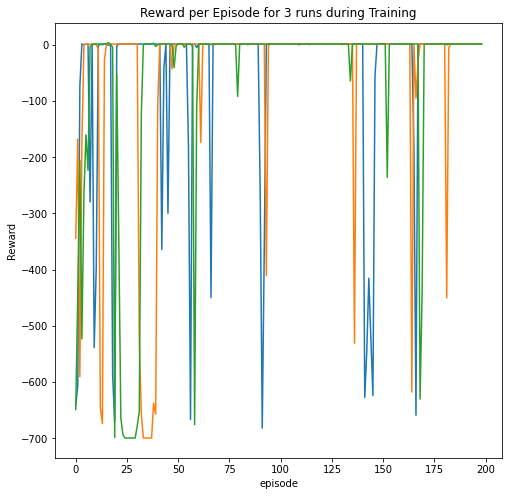

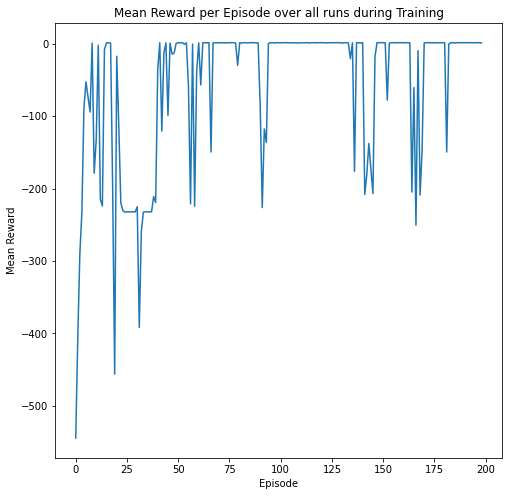

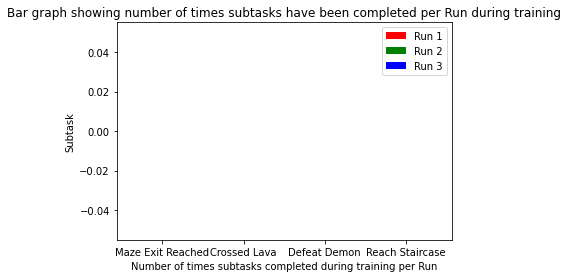

In [ ]:
if __name__ == '__main__': 
    #arrays to store rewards and subtask counts for each run
    allRunScores = []
    allRunCountSubtasks = []

    #do three runs of training
    for i in range(3):
      print()
      print("Training Run "+str(i))
      print("----------------------------------------------------------------")
      #pick random seed for run and pass to main
      seed = np.random.randint(100)
      scores,countSubtask = main(seed)
      #store rewards and subtask counts for run
      allRunScores.append(scores[:199])
      allRunCountSubtasks.append(countSubtask)
      #save arrays of each per run
      np.save(cwd+"/drive/My Drive/Colab Notebooks/Actor Critic Agents/Actor Critic - Limited Actions Agent/scoresRun"+str(i)+".npy", np.array(scores), allow_pickle=True)
      np.save(cwd+"/drive/My Drive/Colab Notebooks/Actor Critic Agents/Actor Critic - Limited Actions Agent/subtaskCountsRun"+str(i)+".npy", np.array(countSubtask), allow_pickle=True)

    #make line graph plots showing rewards per episode per run
    plt.figure(figsize=(8,8))
    plt.plot(allRunScores[0],label="Run 1")
    plt.plot(allRunScores[1],label="Run 2")
    plt.plot(allRunScores[2],label="Run 3")
    plt.ylabel("Reward")
    plt.xlabel("episode")
    plt.title("Reward per Episode for 3 runs during Training")
    plt.savefig(cwd+'/drive/My Drive/Colab Notebooks/Actor Critic Agents/Actor Critic - Limited Actions Agent/img/ACLimitedActions-Training Rewards Per Runs.png')
    plt.show()

    #make line graphs showing average reward from runs
    allRunScoresMean = np.mean(np.array(allRunScores),axis = 0)
    np.save(cwd+"/drive/My Drive/Colab Notebooks/Actor Critic Agents/Actor Critic - Limited Actions Agent/scoresMean.npy", allRunScoresMean, allow_pickle=True)
    plt.figure(figsize=(8,8))
    plt.plot(allRunScoresMean)
    plt.ylabel("Mean Reward")
    plt.xlabel("Episode")
    plt.title("Mean Reward per Episode over all runs during Training")
    plt.savefig(cwd+'/drive/My Drive/Colab Notebooks/Actor Critic Agents/Actor Critic - Limited Actions Agent/img/ACLimitedActions-Mean Training Rewards.png')
    plt.show()

    #make multiple bar plot showing subtask counts completed per run
    N = 4
    ind = np.arange(N) 
    width = 0.25
    allRunCountSubtasks = np.array(allRunCountSubtasks)
    xvals = allRunCountSubtasks[0]
    bar1 = plt.bar(ind, xvals, width, color = 'r') 
    yvals = allRunCountSubtasks[1]
    bar2 = plt.bar(ind+width, yvals, width, color='g')     
    zvals = allRunCountSubtasks[2]
    bar3 = plt.bar(ind+width*2, zvals, width, color = 'b')
    plt.ylabel("Subtask")
    plt.xlabel("Number of times subtasks completed during training per Run")
    plt.title("Bar graph showing number of times subtasks have been completed per Run during training")
    plt.xticks(ind+width,['Maze Exit Reached', 'Crossed Lava', 'Defeat Demon', 'Reach Staircase'])
    plt.legend( (bar1, bar2, bar3), ('Run 1', 'Run 2', 'Run 3') )
    plt.savefig(cwd+'/drive/My Drive/Colab Notebooks/Actor Critic Agents/Actor Critic - Limited Actions Agent/img/ACLimitedActions-SubtasksPlotPerRun.png')
    plt.show()